In [23]:
# Librerías necesarias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler

In [12]:
# Carga de los datos (sustituye esto por tu dataset)
df = pd.read_csv('../data/spotify_clean.csv')

In [14]:
df.columns

Index(['Unnamed: 0', 'genre', 'artist_name', 'track_name', 'track_id',
       'popularity', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence', 'popularity_class',
       'duration_s'],
      dtype='object')

In [15]:
df = df.drop(columns=['genre', 'artist_name', 'track_name', 'track_id','Unnamed: 0','key','time_signature', 'mode','popularity','duration_s','valence','tempo','time_signature'])

In [16]:
df.columns

Index(['acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'loudness', 'speechiness', 'popularity_class'],
      dtype='object')

In [17]:
#Target definicion
X = df.drop(columns=["popularity_class"], axis = 1)
y = df["popularity_class"]

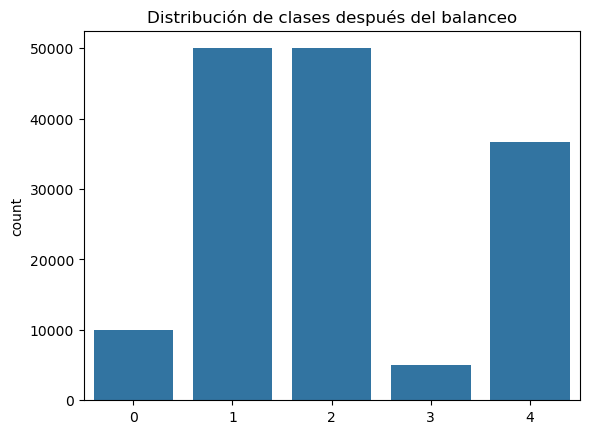

c:\Users\celia\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
4741/4741 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - accuracy: 0.3510 - loss: 1.3029 - val_accuracy: 0.3496 - val_loss: 1.3510
Epoch 2/50
4741/4741 ━━━━━━━━━━━━━━━━━━━━ 28s 6ms/step - accuracy: 0.3811 - loss: 1.2053 - val_accuracy: 0.3245 - val_loss: 1.3175
Epoch 3/50
4741/4741 ━━━━━━━━━━━━━━━━━━━━ 28s 6ms/step - accuracy: 0.3871 - loss: 1.1747 - val_accuracy: 0.3981 - val_loss: 1.2627
Epoch 4/50
4741/4741 ━━━━━━━━━━━━━━━━━━━━ 27s 6ms/step - accuracy: 0.3896 - loss: 1.1524 - val_accuracy: 0.3298 - val_loss: 1.3415
Epoch 5/50
4741/4741 ━━━━━━━━━━━━━━━━━━━━ 50s 8ms/step - accuracy: 0.3872 - loss: 1.1427 - val_accuracy: 0.3720 - val_loss: 1.2774
Epoch 6/50
4741/4741 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.3907 - loss: 1.1219 - val_accuracy: 0.3411 - val_loss: 1.3187
Epoch 7/50
4741/4741 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.3920 - loss: 1.1181 - val_accuracy: 0.3357 - val_loss: 1.2991
Epoch 8/50
4741/4741 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.3951 - loss: 1

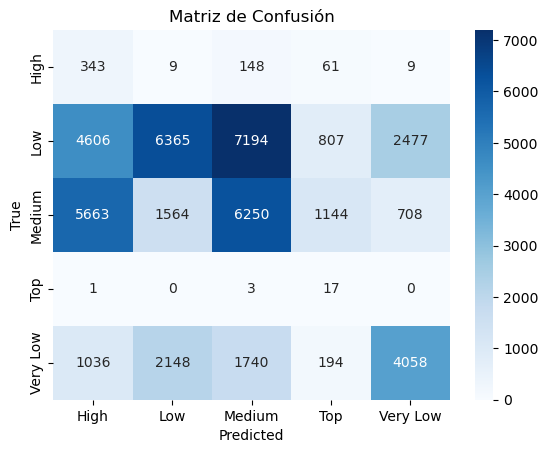

Clases codificadas: ['High' 'Low' 'Medium' 'Top' 'Very Low']


In [26]:
# Importaciones necesarias
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter

# División inicial
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Balanceo de clases con SMOTE y submuestreo en X_train
smote = SMOTE(sampling_strategy={"High": 10000, "Top": 5000}, random_state=42)
under = RandomUnderSampler(sampling_strategy={"Low": 50000, "Medium": 50000}, random_state=42)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
X_train_resampled, y_train_resampled = under.fit_resample(X_train_resampled, y_train_resampled)

# Convertir etiquetas categóricas a números
label_encoder = LabelEncoder()
y_train_resampled = label_encoder.fit_transform(y_train_resampled)
y_test = label_encoder.transform(y_test)

# Escalado de las características
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

# PCA (opcional)
pca = PCA(n_components=0.90)
X_train_resampled = pca.fit_transform(X_train_resampled)
X_test = pca.transform(X_test)

# Verificación del balanceo
sns.countplot(x=y_train_resampled)
plt.title("Distribución de clases después del balanceo")
plt.show()

# Pesos de las clases
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_resampled),
    y=y_train_resampled
)
class_weights = {i: weight for i, weight in enumerate(class_weights)}

# Construcción de la red neuronal
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_resampled.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(np.unique(y_train_resampled)), activation='softmax')
])

# Compilación del modelo
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Entrenamiento del modelo
history = model.fit(
    X_train_resampled, y_train_resampled,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    class_weight=class_weights,
    verbose=1
)

# Evaluación del modelo
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Reporte de clasificación
y_pred = np.argmax(model.predict(X_test), axis=1)
print(classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusión')
plt.show()

# Mostrar clases codificadas
print("Clases codificadas:", label_encoder.classes_)
